# Detailed analysis of the extracted segmentation informations and growth rates

In [2]:
from acia.segm.omero.utils import list_image_ids_in
from acia.segm.omero.storer import BlitzConn

In [3]:
# Johanna Data Omero Id
project_id = 504

In [4]:
username = "<username>"
password = "<password>"
host = "omero"

with BlitzConn(username, password, host) as omero_conn:
    image_ids = list_image_ids_in(project_id, "project", omero_conn)
    
print(len(image_ids))

303


In [5]:
from pathlib import Path
import logging
from tqdm.auto import tqdm

for image_id in tqdm(image_ids):
    result_path = Path("automated_executions") / f"execution_{image_id}" / "tmp"
    
    if not result_path.exists():
        logging.warn("Result path does note exist")

  0%|          | 0/303 [00:00<?, ?it/s]

In [6]:
import pandas as pd

dfs = []
for image_id in tqdm(image_ids):
    result_path = Path("automated_executions") / f"execution_{image_id}" / "tmp"
    loc_df = pd.read_csv(result_path / "allcells.csv", decimal=".", sep=";")
    loc_df["image_id"] = image_id
    dfs.append(loc_df)

  0%|          | 0/303 [00:00<?, ?it/s]

In [7]:
all_df = pd.concat(dfs)

In [8]:
all_df

,Unnamed: 0,area,length,id,frame,time,image_id
0,0,2.355521,2.502978,0,0,0.00,975
1,1,2.867591,2.876246,1,0,0.00,975
2,2,2.683246,2.624959,2,0,0.00,975
3,3,3.023260,3.042053,3,0,0.00,975
4,4,0.872567,1.086190,4,0,0.00,975
...,...,...,...,...,...,...,...
3756,3864,1.880320,2.206632,3864,95,23.75,26195
3757,3865,2.027797,2.312313,3865,95,23.75,26195
3758,3866,1.200292,1.448253,3866,95,23.75,26195
3759,3867,2.330942,2.550235,3867,95,23.75,26195


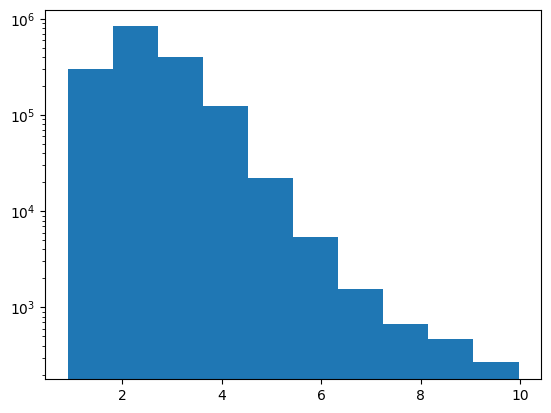

In [9]:
import matplotlib.pyplot as plt
plt.hist(all_df["length"])
plt.yscale("log")

In [10]:
all_df[(all_df["length"] > 100) & (all_df["length"] < 200)]

,Unnamed: 0,area,length,id,frame,time,image_id


In [11]:
from acia.segm.omero.utils import getImage

def get_image_size(image_id: int):
    with BlitzConn(username, password, host) as conn:
        image = getImage(conn, image_id)

        width = image.getSizeX()
        height = image.getSizeY()

        return width * height

In [12]:
from sklearn.metrics import r2_score

def linear_regression(x,y):
    # linear regression to the log of the counts
    params, _, _, _, _ = np.polyfit(x, np.log(y), 1, full=True)

    # following exponential model: N(t) = N_0 * np.exp(mu * t)
    N_0 = np.exp(params[1])
    mu = params[0]

    y_pred = N_0 * np.exp(x * mu)

    R2 = r2_score(y, y_pred)
    
    return N_0, mu, R2

def compute_gr(data):
    (x, y), selected = data
    # perform linear regression
    N_0, mu, R2 = linear_regression(x[selected], y[selected])
    
    return {"N_0": N_0, "mu": mu, "R2": R2}

In [13]:
def aug_dict(data, new_key):
    items = list(data.keys())
    for item in items:
        val = data.pop(item)
        data[new_key + item] = val
        
    return data

In [14]:
import pandas as pd
import numpy as np

image_id = 975

def compute_growth_rates(image_id, min_cell_number=8, max_chamber_filling=0.8):

    result_path = Path("automated_executions") / f"execution_{image_id}" / "tmp"

    minutes_between_frames = 15

    # import merged colony area development
    colony = pd.read_csv(result_path / "colony_area.csv")
    colony["time"] = colony["frame"] * 15/60 # image every 15 minutes


    # import individual cell data
    individual_cells = pd.read_csv(result_path / "allcells.csv", decimal=".", sep=";")
    individual_cells["time"] = individual_cells["frame"] * 15/60 # image every 15 minutes

    counts = individual_cells.groupby(["frame", "time"]).size().to_frame("counts").reset_index()

    min_frame = np.min(counts[counts["counts"] >= min_cell_number]["frame"])

    sum_df = individual_cells.groupby(["frame", "time"]).agg("sum").reset_index()
    
    max_area = np.max(sum_df["area"])
    
    sum_df["fill_percentage"] = sum_df["area"] / max_area

    max_frame = np.max(sum_df[sum_df["fill_percentage"] < max_chamber_filling]["frame"])

    print(image_id, min_frame, max_frame)
    
    if np.isnan(min_frame):
        print(f"Skip {image_id}")
        return []

    selected = (colony["frame"] >= min_frame) & (colony["frame"] <= max_frame)
    
    def get_data(df, name):
        x = (df["time"]).to_numpy() # time in hours
        # y is the area of the colony at a certain frame
        y = df[name]

        return x,y

    def get_colony_data():
        return get_data(colony, "area"), selected

    def get_cell_count_data():
        return get_data(counts, "counts"), selected

    def get_area_data():
        areas = individual_cells.groupby(["frame", "time"])["area"].agg("sum").reset_index(name="area")

        return get_data(areas, "area"), selected

    def get_length_data():
        lengths = individual_cells.groupby(["frame", "time"])["length"].agg("sum").reset_index(name="length")

        return get_data(lengths, "length"), selected
    
    colony_gr = compute_gr(get_colony_data())
    count_gr = compute_gr(get_cell_count_data())
    area_gr = compute_gr(get_area_data())
    length_gr = compute_gr(get_length_data())
    
    methods = ["colony", "count", "area", "length"]
    
    return [{"image_id": image_id, "method": method, **data} for data,method in zip((colony_gr, count_gr, area_gr, length_gr) , methods)]  #{"image_id": image_id, **aug_dict(colony_gr, "colony_gr_"), **aug_dict(count_gr, "count_gr_"), **aug_dict(area_gr, "area_gr_"), **aug_dict(length_gr, "length_gr_")} #{"colony_gr": colony_gr, "count_gr": count_gr, "area_gr": area_gr, "length_gr": length_gr}

In [15]:
compute_growth_rates(975)

975 9 37


[{'image_id': 975,
  'method': 'colony',
  'N_0': 1528.6252130997466,
  'mu': 0.4681468784022443,
  'R2': 0.9966596063481356},
 {'image_id': 975,
  'method': 'count',
  'N_0': 3.545036793788817,
  'mu': 0.46300599445372465,
  'R2': 0.9941472052795379},
 {'image_id': 975,
  'method': 'area',
  'N_0': 9.68956006802696,
  'mu': 0.47027607358504103,
  'R2': 0.9943241747074489},
 {'image_id': 975,
  'method': 'length',
  'N_0': 10.08710728801885,
  'mu': 0.4730563282367538,
  'R2': 0.9961264789601402}]

In [16]:
from acia.segm.omero.utils import getImage
import pandas as pd

data = []

with BlitzConn(username, password, host) as omero_conn:
    for image_id in image_ids:
        image = getImage(omero_conn, image_id)

        condition = image.getParent().getName()
        
        data.append({"image_id": image_id, "medium": condition})
        
df_meta = pd.DataFrame(data)
print(np.unique(df_meta["medium"]))
df_meta


['Acetate-MOPS' 'BHI' 'BHI_old' 'Citrat-MOPS' 'Fructose-MOPS'
 'Gluconate-MOPS' 'Glucose-MOPS' 'PCA-Gluc' 'PCA-Gluc_old' 'Pyruvate-MOPS']


,image_id,medium
0,975,Acetate-MOPS
1,976,Acetate-MOPS
2,977,Acetate-MOPS
3,978,Acetate-MOPS
4,979,Acetate-MOPS
...,...,...
298,26191,PCA-Gluc
299,26192,PCA-Gluc
300,26193,PCA-Gluc
301,26194,PCA-Gluc


In [48]:
analysis_image_ids = df_meta[df_meta["medium"].isin(("Acetate-MOPS", "Citrat-MOPS", "Fructose-MOPS", "Gluconate-MOPS", "Glucose-MOPS", "PCA-Gluc", "Pyruvate-MOPS", "BHI"))]["image_id"].to_numpy()

In [49]:
#analysis_image_ids = df_meta["image_id"].to_numpy()
analysis_image_ids

array([  975,   976,   977,   978,   979,   980,   982,   983,   984,
         985,   986,   987,   988,   989,   990,   991,   992,   994,
         995,   996,   997,  1005,   998,   999,  1000,  1001,  1003,
        1004,  1018,  1006,  1008,  1010,  1012,  1014,  1016,  1020,
        1022,  1024,  1032,  1026,  1028,  1030,  1034,  1036,  1038,
        1041,  1043,  1059,  1045,  1048,  1052,  1053,  1056,  1062,
        1009,  1011,  1013,  1015,  1017,  1019,  1021,  1023,  1025,
        1027,  1029,  1031,  1033,  1035,  1037,  1040,  1044,  1046,
        1049,  1060,  1051,  1054,  1057,  1063,  1065,  1067,  1069,
        1070,  1072,  1074,  1076,  1078,  1081,  1082,  1084,  1086,
        1112,  1113,  1114,  1115,  1116,  1117,  1118,  1120,  1122,
        1124,  1126,  1128,  1130,  1132,  1134,  1137,  1140,  1142,
        1145,  1148,  1150,  1153,  1156,  1159,  1161,  1164,  1167,
        1169,  1172,  1175,  1177,  1180,  1182,  1185,  1119,  1121,
        1123,  1125,

In [50]:
min_cell_number = 8

In [51]:
from tqdm.auto import tqdm

outputs = []

for image_id in tqdm(analysis_image_ids):
    outputs += compute_growth_rates(image_id, min_cell_number=min_cell_number)

  0%|          | 0/260 [00:00<?, ?it/s]

975 9 37
976 8 37
977 5 37
978 2 36
979 6 37
980 0 34
982 6 37
983 2 37
984 10 37
985 8 37
986 3 37
987 2 37
988 6 37
989 6 37
990 0 34
991 1 37
992 7 37
994 10 37
995 11 37
996 13 37
997 nan 36
Skip 997
1005 0 17
998 3 17
999 0 17
1000 0 17
1001 0 17
1003 0 17
1004 1 17
1018 0 17
1006 1 17
1008 0 17
1010 2 17
1012 0 17
1014 1 17
1016 0 17
1020 0 17
1022 0 17
1024 1 17
1032 0 17
1026 0 17
1028 1 17
1030 1 18
1034 4 17
1036 1 17
1038 1 17
1041 0 17
1043 1 17
1059 0 17
1045 0 17
1048 0 17
1052 0 17
1053 2 17
1056 1 17
1062 0 17
1009 5 27
1011 5 28
1013 4 24
1015 6 28
1017 8 29
1019 6 25
1021 7 29
1023 6 29
1025 6 27
1027 3 28
1029 2 25
1031 7 30
1033 6 28
1035 4 26
1037 4 27
1040 5 27
1044 9 32
1046 4 24
1049 10 32
1060 0 21
1051 0 20
1054 4 24
1057 0 19
1063 8 27
1065 9 31
1067 7 29
1069 6 27
1070 7 31
1072 10 33
1074 4 27
1076 9 31
1078 7 29
1081 5 29
1082 5 27
1084 7 27
1086 7 29
1112 0 26
1113 0 26
1114 1 26
1115 6 27
1116 6 27
1117 11 27
1118 4 27
1120 1 27
1122 4 27
1124 4 27
1126 

In [52]:
df = pd.DataFrame(outputs)
df

,image_id,method,N_0,mu,R2
0,975,colony,1528.625213,0.468147,0.996660
1,975,count,3.545037,0.463006,0.994147
2,975,area,9.689560,0.470276,0.994324
3,975,length,10.087107,0.473056,0.996126
4,976,colony,1044.543084,0.484007,0.998713
...,...,...,...,...,...
1031,26194,length,14.095180,0.162663,0.915309
1032,26195,colony,684.869020,0.185100,0.887978
1033,26195,count,2.341331,0.193151,0.905222
1034,26195,area,4.842251,0.176846,0.914440
